### Read Videos & Convert to Frames

In [1]:
import os
import logging
import subprocess

In [62]:
def create_folders_and_export_videos(directory_path):
    logging.basicConfig(level=logging.INFO) 

    # List all .svo video files in the specified directory
    svo_files = [file for file in os.listdir(directory_path) if file.lower().endswith('.svo')]

    # Create 'file2' folder if not exists (the folder holding the frames of each video)
    image_folder_path = os.path.join('C:/Users/user/Downloads/file2')
    if not os.path.exists(image_folder_path):
        os.makedirs(image_folder_path)
        logging.info(f"Folder 'image' created at {image_folder_path}")

    # Process each .svo video file
    for svo_file in svo_files:
        video_path = os.path.join(directory_path, svo_file)
        output_path = os.path.join(image_folder_path, os.path.splitext(svo_file)[0])

        # Check if the folder already exists
        if not os.path.exists(output_path):
            os.makedirs(output_path)
            logging.info(f"Folder '{os.path.splitext(svo_file)[0]}' created at {output_path}")
        else:
            logging.info(f"Folder '{os.path.splitext(svo_file)[0]}' already exists at {output_path}")

        # Run ZED_SVO_Export.exe command for .svo files (must be run from the same directory as the SDK so change the directories first)
        zed_sdk_bin_path = 'C:/Program Files (x86)/ZED SDK/samples/bin'
        os.chdir(zed_sdk_bin_path)
        command = f'ZED_SVO_Export.exe "{video_path}" "{output_path}/" 3'
        subprocess.run(command, shell=True)

        # Check the exported files and delete those that do not start with "left" (we don't want the depth information)
        exported_files = [file for file in os.listdir(output_path) if file.lower().endswith('.png')]
        for exported_file in exported_files:
            if not exported_file.lower().startswith('left'):
                file_path = os.path.join(output_path, exported_file)
                os.remove(file_path)
                logging.info(f"File '{exported_file}' deleted as it does not start with 'left'")

        print(f".svo file '{svo_file}' exported and saved in '{output_path}'")

In [63]:
directory_path = 'C:/Users/user/Downloads/file'
create_folders_and_export_videos(directory_path)

INFO:root:Folder 'f_HQ059_rec0' created at C:/Users/user/Downloads/file2\f_HQ059_rec0
INFO:root:File 'depth000000.png' deleted as it does not start with 'left'
INFO:root:File 'depth000001.png' deleted as it does not start with 'left'
INFO:root:File 'depth000002.png' deleted as it does not start with 'left'
INFO:root:File 'depth000003.png' deleted as it does not start with 'left'
INFO:root:File 'depth000004.png' deleted as it does not start with 'left'
INFO:root:File 'depth000005.png' deleted as it does not start with 'left'
INFO:root:File 'depth000006.png' deleted as it does not start with 'left'
INFO:root:File 'depth000007.png' deleted as it does not start with 'left'
INFO:root:File 'depth000008.png' deleted as it does not start with 'left'
INFO:root:File 'depth000009.png' deleted as it does not start with 'left'
INFO:root:File 'depth000010.png' deleted as it does not start with 'left'
INFO:root:File 'depth000011.png' deleted as it does not start with 'left'
INFO:root:File 'depth00001

.svo file 'f_HQ059_rec0.svo' exported and saved in 'C:/Users/user/Downloads/file2\f_HQ059_rec0'


### Convert to Grayscale

In [4]:
from matplotlib import pyplot as plt
import cv2
import numpy as np

In [5]:
def convertToGrayScale(directory_path):
    # List all frames of the video in the folder with the specified directory_path
    videoFrames = [frame for frame in os.listdir(directory_path)]       # name of file

    # List all 
    grayImagesList = [] 
    for frame in videoFrames:
        frame_path = os.path.join(directory_path, frame)
        grayImage = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        grayImagesList.append(grayImage.astype(np.int16))

    return grayImagesList

In [64]:
# directory_path = 'C:/Users/user/Downloads/file2/f_AS069_rec0/'
directory_path = 'C:/Users/user/Downloads/file2/f_HQ059_rec0/'
grayImagesList = convertToGrayScale(directory_path)

In [7]:
type(grayImagesList[0].dtype)

numpy.dtype[int16]

### Directional ATD

##### The process of ATD involves using thresholds to set insignificant differences of pixel values to 0. Insignificant differences represent minimal to no change in motion between two frames. For the difference of any two frames in a sequence, extreme or ‘noise’ values are set to 0 to reduce the effect on the average pixel value. For example, absolute values below 13 can be set to 0 and thoseabove 13 are kept as is. Afterwards, the average of the pixel values μ of the differenced frame is taken and used as the threshold for setting insignificant differences to 0 and significant ones to 1. This process, known as binarization, is performed for every pair of sequential frames. Once complete, the values of all differences are accumulated, resulting in one frame with pixel values indicating significant change in motion over a sequence of time.

In [8]:
from matplotlib import pyplot as plt 
import numpy as np

In [9]:
def performThreshold(diffFrame):
    mask = (diffFrame < 13) & (diffFrame > -13)
    diffFrame[mask] = 0
    return diffFrame

In [10]:
def binarize(noiseless_image):
    mean = np.mean(noiseless_image)
    maskZeroes = (noiseless_image < mean)
    maskOnes = (noiseless_image >= mean)
    binarizedImage = noiseless_image
    binarizedImage[maskZeroes] = 0
    binarizedImage[maskOnes] = 1
    return binarizedImage

In [11]:
def accumulateFrames(framesList):
    accumulatedFrame = framesList[0]

    for i in range(1, len(framesList)):
        accumulatedFrame += framesList[i]
    
    return accumulatedFrame

In [12]:
def applyForwardDiff(grayImagesList):
    listOfFrames = []

    for index in range(len(grayImagesList) - 1):
        forward_ImageDiff = grayImagesList[index] - grayImagesList[index + 1]
        forward_ImageDiff = performThreshold(forward_ImageDiff)
        binarizedImage = binarize(forward_ImageDiff)             
        listOfFrames.append(binarizedImage)
    
    return accumulateFrames(listOfFrames)

In [13]:
def applyBackwardDiff(grayImagesList):
    listOfFrames = []

    for index in range(1, len(grayImagesList)):
        backward_ImageDiff = grayImagesList[index] - grayImagesList[index - 1]
        backward_ImageDiff = performThreshold(backward_ImageDiff)
        binarizedImage = binarize(backward_ImageDiff) 
        listOfFrames.append(binarizedImage)
    
    return accumulateFrames(listOfFrames)

In [14]:
def applyBiDirectionalDiff(grayImagesList):
    listOfFrames = []

    for index in range(1, len(grayImagesList)-1):
        average_frame = np.mean([grayImagesList[index - 1], grayImagesList[index + 1]], axis=0)
        bidirectional_ImageDiff = grayImagesList[index] - average_frame
        bidirectional_ImageDiff = performThreshold(bidirectional_ImageDiff)
        binarizedImage = binarize(bidirectional_ImageDiff)
        listOfFrames.append(binarizedImage)
    
    return accumulateFrames(listOfFrames)

In [41]:
def applyATD(frames):
    forwardATD = applyForwardDiff(frames)
    backwardATD = applyBackwardDiff(frames)
    bidirectATD = applyBiDirectionalDiff(frames)
    
    return [forwardATD, backwardATD, bidirectATD]

In [66]:
noFrames = len(grayImagesList)
noWords = 1
split = noFrames // noWords

In [67]:
# imageATDs = []
# for i in range(noWords):
#     index = split * i
#     imageATDs.append(applyATD(grayImagesList[index: index + split]))

In [68]:
forwardATD = applyForwardDiff(grayImagesList)
backwardATD = applyBackwardDiff(grayImagesList)
bidirectATD = applyBiDirectionalDiff(grayImagesList)

In [69]:
print("Forward ATD: ", forwardATD)
print("Backward ATD: ", backwardATD)
print("Bidirectional ATD", bidirectATD)

Forward ATD:  [[158 158 158 ... 158 158 158]
 [158 158 158 ... 158 158 158]
 [158 158 158 ... 158 158 158]
 ...
 [158 158 158 ... 158 158 158]
 [158 158 158 ... 158 158 158]
 [158 158 158 ... 158 158 158]]
Backward ATD:  [[162 162 162 ... 162 162 162]
 [162 162 162 ... 162 162 162]
 [162 162 162 ... 162 162 162]
 ...
 [162 162 162 ... 162 162 162]
 [162 162 162 ... 162 162 162]
 [162 162 162 ... 162 162 162]]
Bidirectional ATD [[188. 188. 188. ... 188. 188. 188.]
 [188. 188. 188. ... 188. 188. 188.]
 [188. 188. 188. ... 188. 188. 188.]
 ...
 [188. 188. 188. ... 188. 188. 188.]
 [188. 188. 188. ... 188. 188. 188.]
 [188. 188. 188. ... 188. 188. 188.]]


(-0.5, 1279.5, 719.5, -0.5)

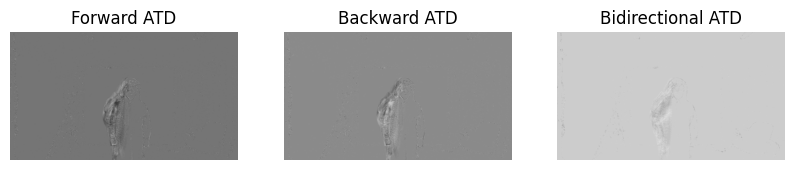

In [70]:
plt.figure(figsize = (10, 10))

# for i in range(len(imageATDs)):
#     for j in range(len(imageATDs[i])):
#         size = len(imageATDs) * len(imageATDs[i])
#         plt.subplot(i + 1, size, j + 1)
#         plt.imshow(imageATDs[i][j], cmap = 'gray')
#         plt.axis('off')

plt.subplot(1, 3, 1)
plt.imshow(forwardATD, cmap = 'gray')
plt.title('Forward ATD')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(backwardATD, cmap = 'gray')
plt.title('Backward ATD')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(bidirectATD, cmap = 'gray')
plt.title('Bidirectional ATD')
plt.axis('off')

(-0.5, 1279.5, 719.5, -0.5)

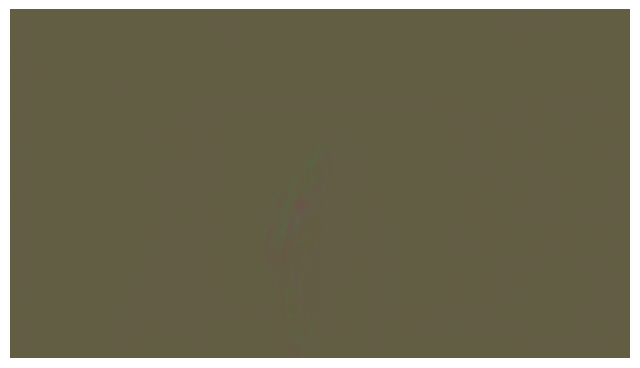

In [100]:
image_with_ATD = np.dstack((forwardATD, backwardATD, bidirectATD))

rgb_image = (image_with_ATD * 255).astype(np.uint8)

plt.figure(figsize = (8, 6))
plt.imshow(rgb_image)
plt.axis('off')